# Demand Forecasting with Prophet + LSTM Ensemble

This notebook shows end-to-end code to:
1. Generate synthetic semiconductor-style weekly demand data
2. Visualize the time series
3. Train a **Prophet** model
4. Train an **LSTM** model
5. Build an **ensemble forecast** combining Prophet + LSTM
6. Compare performance using MAE and plots



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from prophet import Prophet
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense


c:\Users\indmi_q2tg30l\OneDrive\Documents\Documents\VSCode\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Generate sample weekly demand data
np.random.seed(42)

# Weekly demand over 52 weeks

weeks = pd.date_range('2024-01-01', periods=150, freq='W')
demand = 1000 + 150 * np.sin(np.linspace(0, 3*np.pi, 150)) \
         + np.random.randint(-80, 80, 150)


# Synthetic forecast (noisy version of demand)
forecast = demand + np.random.randint(-60, 60, 150)

df = pd.DataFrame({'ds': weeks, 'y': demand})
#df.head()

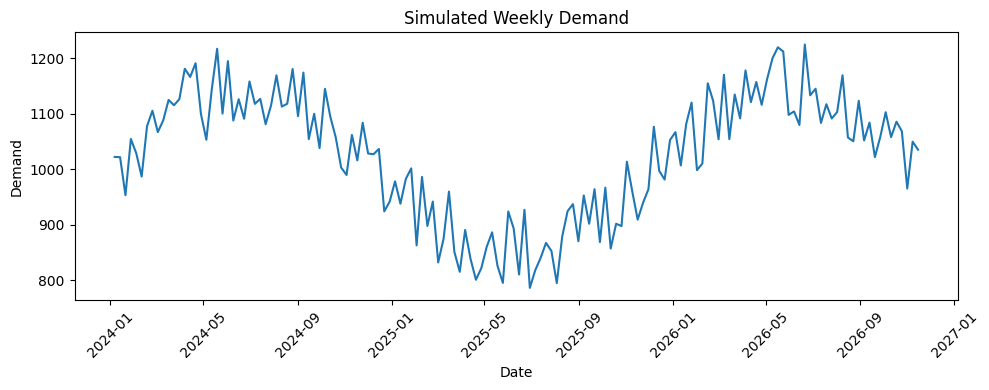

In [3]:
## Plot the sample demand
plt.figure(figsize=(10,4))
plt.plot(df['ds'], df['y'])
plt.title('Simulated Weekly Demand')
plt.xlabel('Date')
plt.ylabel('Demand')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [4]:
## Train / test split
train_size = 120
df_train = df.iloc[:train_size].copy()
df_test  = df.iloc[train_size:].copy()

print('Train shape:', df_train.shape)
print('Test shape :', df_test.shape)

Train shape: (120, 2)
Test shape : (30, 2)


In [ ]:
###Train Prophet model
m_prophet = Prophet(
    yearly_seasonality=False,
    weekly_seasonality=False,
    daily_seasonality=False,
)
m_prophet.add_seasonality(name='custom_season', period=52, fourier_order=5)

m_prophet.fit(df_train)

# Forecast into the test horizon
future = m_prophet.make_future_dataframe(periods=len(df_test), freq='W')
forecast_prophet = m_prophet.predict(future)

forecast_prophet.tail()

13:01:37 - cmdstanpy - INFO - Chain [1] start processing
13:01:37 - cmdstanpy - INFO - Chain [1] done processing


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,custom_season,custom_season_lower,custom_season_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
145,2026-10-18,1331.918518,1231.260178,1396.702991,1278.799681,1387.563370,-18.224326,-18.224326,-18.224326,-18.224326,-18.224326,-18.224326,0.0,0.0,0.0,1313.694192
146,2026-10-25,1339.326767,1246.240384,1412.373500,1282.674512,1397.947818,-11.024502,-11.024502,-11.024502,-11.024502,-11.024502,-11.024502,0.0,0.0,0.0,1328.302265
147,2026-11-01,1346.735015,1278.920368,1447.347746,1286.264862,1409.176615,15.911209,15.911209,15.911209,15.911209,15.911209,15.911209,0.0,0.0,0.0,1362.646224
148,2026-11-08,1354.143264,1293.299738,1470.783786,1290.882116,1419.641287,26.838617,26.838617,26.838617,26.838617,26.838617,26.838617,0.0,0.0,0.0,1380.981881
149,2026-11-15,1361.551512,1283.792011,1457.889606,1294.830036,1431.182311,9.140739,9.140739,9.140739,9.140739,9.140739,9.140739,0.0,0.0,0.0,1370.692251


In [6]:
## Align Prophet predictions with the test period
yhat_prophet_test = (
    forecast_prophet.set_index('ds')
    .loc[df_test['ds'], 'yhat']
    .values
)
print('Prophet test predictions:', yhat_prophet_test.shape)

Prophet test predictions: (30,)


In [ ]:
## Prepare data for LSTM
scaler = MinMaxScaler()
y_scaled = scaler.fit_transform(df[['y']].values)

n_lags = 8  # use last 4 weeks to predict the next

def create_sequences(data, n_lags):
    X, y = [], []
    for i in range(len(data) - n_lags):
        X.append(data[i:i+n_lags])
        y.append(data[i+n_lags])
    return np.array(X), np.array(y)

X_all, y_all = create_sequences(y_scaled, n_lags)
dates_seq = df['ds'].values[n_lags:]

split_idx = train_size - n_lags
X_train, X_test = X_all[:split_idx], X_all[split_idx:]
y_train, y_test = y_all[:split_idx], y_all[split_idx:]

X_train.shape, X_test.shape

((116, 4, 1), (30, 4, 1))

In [8]:
## Build and train LSTM model
model_lstm = Sequential([
    LSTM(32, input_shape=(n_lags, 1)),
    Dense(1)
])

model_lstm.compile(loss='mse', optimizer='adam')

history = model_lstm.fit(
    X_train, y_train,
    epochs=45,
    batch_size=16,
    verbose=1,
    validation_split=0.1
)

Epoch 1/45


c:\Users\indmi_q2tg30l\OneDrive\Documents\Documents\VSCode\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.2895 - val_loss: 0.4489
Epoch 2/45
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.2106 - val_loss: 0.3264
Epoch 3/45
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.1460 - val_loss: 0.2186
Epoch 4/45
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0899 - val_loss: 0.1305
Epoch 5/45
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0517 - val_loss: 0.0635
Epoch 6/45
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0302 - val_loss: 0.0272
Epoch 7/45
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0250 - val_loss: 0.0171
Epoch 8/45
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0270 - val_loss: 0.0163
Epoch 9/45
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0250 - val_loss: 0.0197
Epoch 10/45
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0230 - val_loss: 0.0243
Epoch 11/45
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0223 - val_loss: 0.0268
Epoch 12/45
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0216 - val_loss: 0.0252
Epoch 13/45


In [9]:
## Generate LSTM predictions on test set
yhat_lstm_test_scaled = model_lstm.predict(X_test)
yhat_lstm_test = scaler.inverse_transform(yhat_lstm_test_scaled).ravel()

len_test = min(len(yhat_prophet_test), len(yhat_lstm_test))
y_test_aligned = df_test['y'].values[-len_test:]
yhat_prophet_aligned = yhat_prophet_test[-len_test:]
yhat_lstm_aligned = yhat_lstm_test[-len_test:]

len(y_test_aligned), len(yhat_prophet_aligned), len(yhat_lstm_aligned)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step


(30, 30, 30)

In [10]:
## Simple weighted ensemble & evaluation
w1, w2 = 0.5, 0.5
yhat_ensemble = w1 * yhat_prophet_aligned + w2 * yhat_lstm_aligned

mae_prophet = mean_absolute_error(y_test_aligned, yhat_prophet_aligned)
mae_lstm    = mean_absolute_error(y_test_aligned, yhat_lstm_aligned)
mae_ensemble = mean_absolute_error(y_test_aligned, yhat_ensemble)

print('MAE Prophet :', mae_prophet)
print('MAE LSTM    :', mae_lstm)
print('MAE Ensemble:', mae_ensemble)

MAE Prophet : 164.5598799582622
MAE LSTM    : 43.27879617044106
MAE Ensemble: 94.05678499961057


In [11]:
## Learn ensemble weights with linear regression
X_stack = np.vstack([yhat_prophet_aligned, yhat_lstm_aligned]).T
reg = LinearRegression().fit(X_stack, y_test_aligned)
print('Learned weights:', reg.coef_, 'Intercept:', reg.intercept_)

yhat_ensemble_lr = reg.predict(X_stack)
mae_ensemble_lr = mean_absolute_error(y_test_aligned, yhat_ensemble_lr)
print('MAE Ensemble (LR):', mae_ensemble_lr)

Learned weights: [-1.00738677 -0.62515073] Intercept: 3058.746026728208
MAE Ensemble (LR): 29.86325290652546


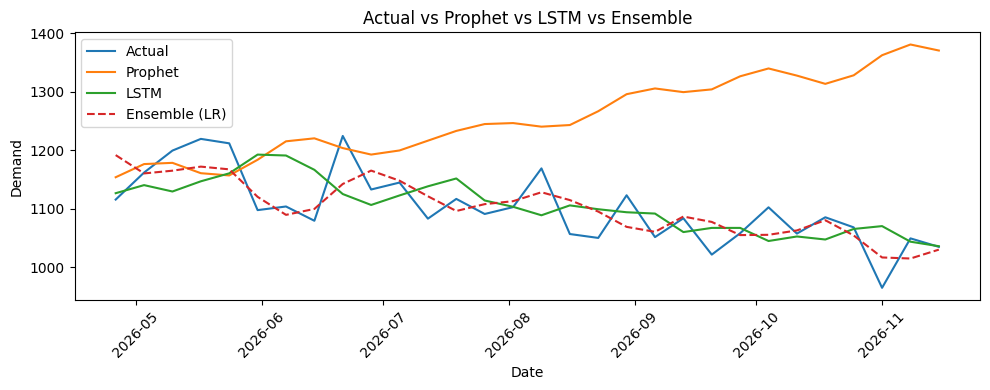

In [12]:
####Plot actual vs Prophet, LSTM, and Ensemble
plt.figure(figsize=(10,4))
plt.plot(df_test['ds'].values[-len_test:], y_test_aligned, label='Actual')
plt.plot(df_test['ds'].values[-len_test:], yhat_prophet_aligned, label='Prophet')
plt.plot(df_test['ds'].values[-len_test:], yhat_lstm_aligned, label='LSTM')
plt.plot(df_test['ds'].values[-len_test:], yhat_ensemble_lr, label='Ensemble (LR)', linestyle='--')
#####plt.plot(df_test['ds'].values[-len_test:], forecast, label='Forecast')
plt.legend()

plt.xticks(rotation=45)
plt.xlabel('Date')
plt.ylabel('Demand')
plt.title('Actual vs Prophet vs LSTM vs Ensemble')
plt.legend()
plt.tight_layout()
plt.show()